<h1 style="font-size: 30px; margin-left:50px">SPAM detector</h1>

<img src="https://gifimage.net/wp-content/uploads/2018/05/spam-gif-6.gif" style="width:20%; float:center;">


In [1]:
# import libraries
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
import xgboost
from sklearn import svm,tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score


import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,Input,LSTM,Dense,Bidirectional,Dropout, Activation
from keras.models import Model
from tensorflow.keras.models import Sequential
tf.__version__
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the data
df = pd.read_csv('../input/spam-filter/emails.csv')
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
# checking the number of duplicate columns
print('Number of duplicate rows in the data are : ',df[df.duplicated(subset=None, keep='first') == True].shape[0], '\nSo we drop them')

# dropping the duplicate columns
df.drop_duplicates(inplace = True)

Number of duplicate rows in the data are :  33 
So we drop them


In [4]:
# Describing the values in the Spam column
df.groupby('spam').describe()

text                                                               
     count unique                                                top freq
spam                                                                     
0     4327   4327  Subject: bill koures  vince ,  alex and i did ...    1
1     1368   1368  Subject: need an outstanding logo now ?  worki...    1

We can see that the 

In [5]:
# creating a column with the length of each message
df['mail_len'] = df.text.apply(len)

## Exploratory Data Analysis

Plotting the histogram of data for the count of Ham and Spam mails

Text(0.5, 0, 'Ham/Spam')

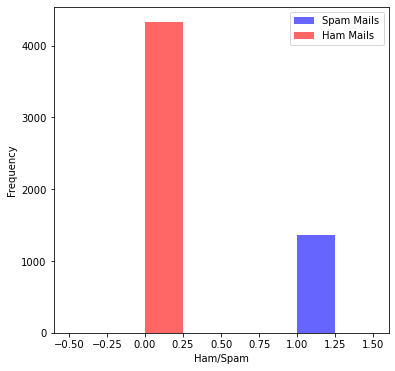

In [6]:
plt.figure(figsize=(6,6))

df.spam[df.spam==1].plot(bins=4, kind='hist', color='blue', 
                                       label='Spam Mails', alpha=0.6)

df.spam[df.spam==0].plot(bins=4, kind='hist', color='red', 
                                       label='Ham Mails', alpha=0.6)
plt.legend()
plt.xlabel("Ham/Spam")

We cam see that the Ham mails are more almost 4 times in number than the spam mails

Plottin the distplot to see the distribution of mail length...bigger the mail lenght, higher the plot goes.

Text(0.5, 1.0, 'Length Histogram')

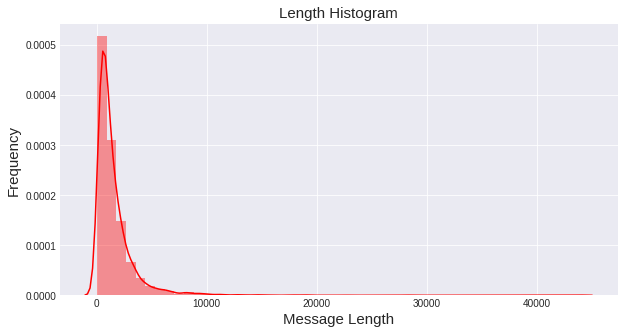

In [7]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,5))
sns.distplot(df['mail_len'],kde=True,color='red',hist=True)
plt.xlabel("Message Length",size=15)
plt.ylabel("Frequency",size=15)
plt.title("Length Histogram",size=15)

We see that the initial rows have got bigger mails than the later ones

Lets see the histogram of length of mails for both the labels in the same plot one over the other

Text(0.5, 0, 'Mail Length')

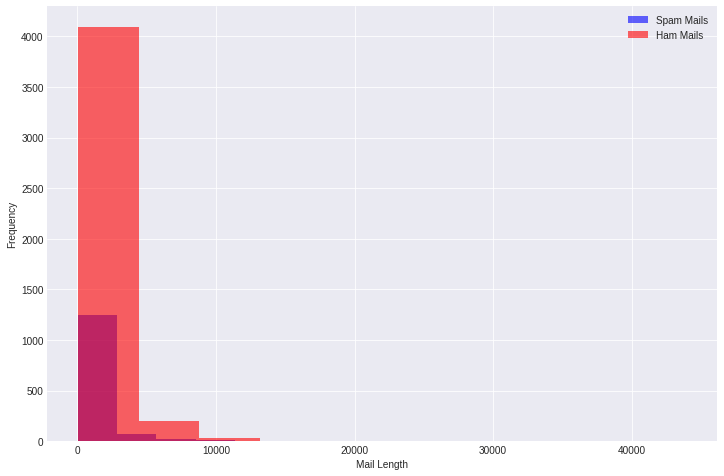

In [8]:
plt.figure(figsize=(12, 8))
df[df.spam==1].mail_len.plot( kind='hist', color='blue',label='Spam Mails', alpha=0.6)
df[df.spam== 0].mail_len.plot(kind='hist', color='red',label='Ham Mails', alpha=0.6)
plt.legend()
plt.xlabel("Mail Length")

## Preprocessing of the text data
In preprocessing we will remove the punctuations and stopwords and lower case all the mails data

In [9]:
#1.Punctuations are [!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]
#2.Stop words in natural language processing, are useless words (data).

def process_text(text):
    
    #1 Remove Punctuationa
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    #2 Remove Stop Words
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    #3 Return a list of clean words
    return clean_words

In [10]:
#Show the processed data
df.text = df.text.apply(process_text)
df.text.head()


0    [Subject, naturally, irresistible, corporate, ...
1    [Subject, stock, trading, gunslinger, fanny, m...
2    [Subject, unbelievable, new, homes, made, easy...
3    [Subject, 4, color, printing, special, request...
4    [Subject, money, get, software, cds, software,...
Name: text, dtype: object

## Vectorization of the text data 

We can not feed text data directly to the models. So we will vectorize each mail into a matrix by tokenizing it, then converting  into numerial vectors and finally padding it to create a matrix of numbers for each mail input.

In [11]:
vocab_size = 10000
max_len = 250

# Tokenize the mails
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(df.text)

# Use text_to_sequence to convert it into vectors
sequences = tok.texts_to_sequences(df.text)

# pad seqence to create a matrix of equal length mails
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

Lets see how the mails look like now.....

In [12]:
sequences_matrix[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    3, 5665,  409, 1652, 3770,
        353,  784, 4271,   50,   59,  297, 6154,   

Okay...So finally the data is ready for training.

### Train Test Split

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sequences_matrix, df.spam, test_size = 0.2, random_state = 1)

We will now train the data on the below ML Models.
Lets make a list of the classification models, fit them on training data and check for their respective accuracies.

In [14]:
models=[RandomForestClassifier(),
        GaussianNB(),
        AdaBoostClassifier(),
        xgboost.XGBClassifier(),
        svm.SVC(),
        tree.DecisionTreeClassifier(),
        KNeighborsClassifier()]

model_names=['Random Forest Classifier',
             'Gaussian Naive Bayes Classifier',
             'Adaboost Classifier',
             'XGBoost Classifier',
             'Support Vector Classifier',
             'Decision Tree Classifier',
             'K Nearest Neighbour Classifier']
accuracy=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
d={'Modelling Algo':model_names,'Accuracy':accuracy} 

[09:03:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


lets put all the models with their accuracies and compare to see whcih one has the highest score.

In [15]:
accuracy_frame=pd.DataFrame.from_dict(d, orient='index').transpose()
accuracy_frame

,Modelling Algo,Accuracy
0,Random Forest Classifier,0.854258
1,Gaussian Naive Bayes Classifier,0.462687
2,Adaboost Classifier,0.817384
3,XGBoost Classifier,0.887621
4,Support Vector Classifier,0.824407
5,Decision Tree Classifier,0.775241
6,K Nearest Neighbour Classifier,0.806848


XGBoost Classifier has the highest score, we will do hyperparameter tuning and see how much the accuracy improves

In [16]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

In [17]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [18]:
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [19]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = xgboost.XGBClassifier()
# Random search of parameters, using 2 fold cross validation, 
# search across 5 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.2min finished


[09:08:34] WARNING: ../src/learner.cc:541: 
Parameters: { bootstrap, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:08:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [20]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': False}

In [21]:
rf_random.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=False,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=80, max_features='auto',
              min_child_weight=1, min_samples_leaf=1, min_samples_split=10,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=2, num_parallel_tree=1, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Evaluating the score with best parameters

In [22]:
rfc = rf_random.best_estimator_
rfc.fit(X_train, y_train)
y_pred1 = rfc.predict(X_test) 
print(confusion_matrix(y_test,y_pred1))
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test,y_pred1))

[09:09:23] WARNING: ../src/learner.cc:541: 
Parameters: { bootstrap, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:09:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[847  19]
 [104 169]]
0.8920105355575065
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       866
           1       0.90      0.62      0.73       273

    accuracy                           0.89      1139
   macro avg       0.89      0.80      0.83      1139
weighted avg       0.89      0.89      0.88      1139


### Accuracy using XGBoost with best parameters does improve improved the accuracy score but its still not satisfactory


### Now lets use a simple single layered LSTM model

https://en.wikipedia.org/wiki/Long_short-term_memory
## What is LSTM and why it is used..

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning.

In theory, classic (or "vanilla") RNNs can keep track of arbitrary long-term dependencies in the input sequences. The problem with vanilla RNNs is computational (or practical) in nature: when training a vanilla RNN using back-propagation, the gradients which are back-propagated can "vanish" (that is, they can tend to zero) or "explode" (that is, they can tend to infinity), because of the computations involved in the process, which use finite-precision numbers. RNNs using LSTM units partially solve the vanishing gradient problem, because LSTM units allow gradients to also flow unchanged.
We also have Bi-directional LSTM which overcomes the drwbacks of LSTM model

[https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/](http://)
## Embedding layer - 
Also we are using an embedding layer before giving the data to the LSTM layer

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments: 
1. input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
2. output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word.
3. input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.



In [23]:
model = Sequential()
model.add(Embedding(vocab_size, 200, input_length=max_len))
model.add(LSTM(32))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 200)          2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                29824     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 2,029,857
Trainable params: 2,029,857
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64)

Epoch 1/5
72/72 [==============================] - 9s 54ms/step - loss: 0.4949 - accuracy: 0.7937 - val_loss: 0.0969 - val_accuracy: 0.9737
Epoch 2/5
72/72 [==============================] - 3s 42ms/step - loss: 0.0431 - accuracy: 0.9938 - val_loss: 0.0587 - val_accuracy: 0.9816
Epoch 3/5
72/72 [==============================] - 3s 37ms/step - loss: 0.0129 - accuracy: 0.9977 - val_loss: 0.0539 - val_accuracy: 0.9833
Epoch 4/5
72/72 [==============================] - 3s 37ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0562 - val_accuracy: 0.9860
Epoch 5/5
72/72 [==============================] - 3s 38ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0533 - val_accuracy: 0.9868


## Model Evaluation

In [25]:
scores = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict_classes(X_test)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('confusion matrix:\n', confusion_matrix(y_pred,y_test))

Test loss: 0.053266752511262894
Test accuracy: 0.9868305325508118
confusion matrix:
 [[861  10]
 [  5 263]]


## So we can see that a simple LSTM model gives an accuracy of 0.98 whereas best ML model had just 0.89.

## So finally we have our machine ready....You feed the message and it will tell you whether its a SPAM or HAM

<img src="https://digitalmarketingbypsk.files.wordpress.com/2017/05/21.gif" style="width:30%; float:center;">


## Thank You........